# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RMSE en el conjunto de prueba **no debe ser superior a 48**.

## Procedimiento.

1. Remuestreo de datos por hora.
2. Analizar los datos
3. Entrenar diferentes modelos. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Probar los datos usando la muestra de test y proporcionar una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

### Importación de librerías

In [1]:
# Manipulación y análisis de datos
import pandas as pd
# Funciones matemáticas
import numpy as np
# Separar conjunto de datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split
# Implementación de modelos de regresión lineal
from sklearn.linear_model import LinearRegression
# Implementación de modelos LGBMR
from lightgbm import LGBMRegressor
# Implementación de modelos CatBoost
from catboost import CatBoostRegressor
# Implementación de modelos RandomForest
from sklearn.ensemble import RandomForestRegressor
# Métrica de evaluación error absoluto medio
from sklearn.metrics import mean_absolute_error
# Métrica de evaluacion MSE
from sklearn.metrics import mean_squared_error
# Funciones matemáticas
import math
# Creación de gráficos
import matplotlib.pyplot as plt
# graficos
import seaborn as sns
# análisis de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.dates as mdates 

### Carga de datos

Se carga el dataframe y se realiza una revision básica para detectar problemas obvios en los datos

In [2]:
# Lectura de csv
data_original = pd.read_csv(
    'datasets/taxi.csv',
    index_col=['datetime'], # Configurar la columna de fechas como indice
    parse_dates=['datetime']) # Convertir los datos a formato de fecha

# Imprimir información del dataframe
print(data_original.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [3]:
# primera visualización del contenido
data_original.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


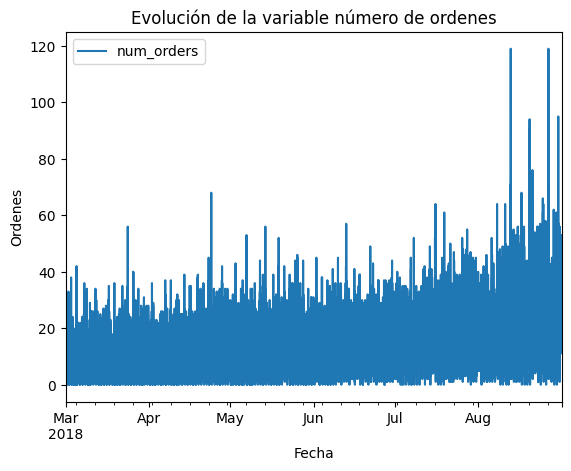

In [4]:
data_original.plot()

# Personalizar la gráfica
plt.title('Evolución de la variable número de ordenes')
plt.xlabel('Fecha')
plt.ylabel('Ordenes')
plt.style.use('ggplot')

# Mostrar la gráfica
plt.show()

#### Revisar si los valores del indice se encuentran en orden cronológico

In [5]:
# Revisión del orden cronológico de los datos de fechas
    # Si es True están en orden correcto
print('Revisión inicial del orden cronológico: ', data_original.index.is_monotonic_increasing)

Revisión inicial del orden cronológico:  True


#### Remuestreo de datos por cada hora

In [6]:
# Aplicar resample por intervalos de 1 hora
data_resample = data_original.resample('1h').sum()

print(data_resample.head())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


In [7]:
# Tamaño  actual de DF
print(data_resample.shape)

(4416, 1)


<div class="alert alert-block alert-info">
<b>Conclusión parcial</b> <a class="tocSkip"></a>

- Se cargan los datos y se configura la columna de fechas como tipo de dato `datetime`, además se usa como indice
- Se comprueba que los datos están ordenados de manera cronológica y sin datos ausentes
- Se aplica un `resample` para agrupar los datos por hora
    - de 26,496 se reduce a 4,416 registros

</div>

## Análisis

#### Gráfica de los datos con resample de 1 hora

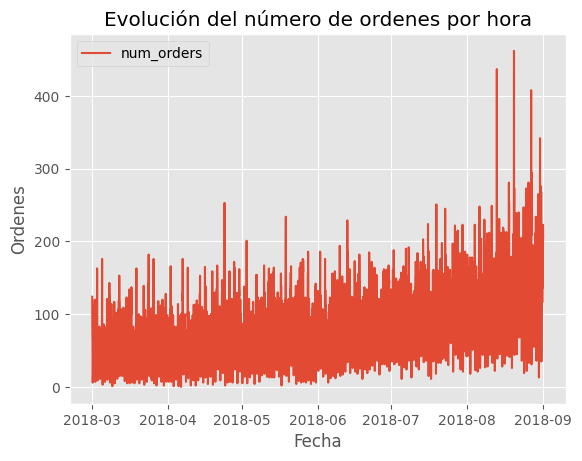

In [8]:
# Creación de la gráfica
sns.lineplot(data_resample)

# Personalizar la gráfica
plt.title('Evolución del número de ordenes por hora')
plt.xlabel('Fecha')
plt.ylabel('Ordenes')

plt.style.use('ggplot')

# Mostrar la gráfica
plt.show()

#### Gráfica de tendencia, estacionalidad y residuo

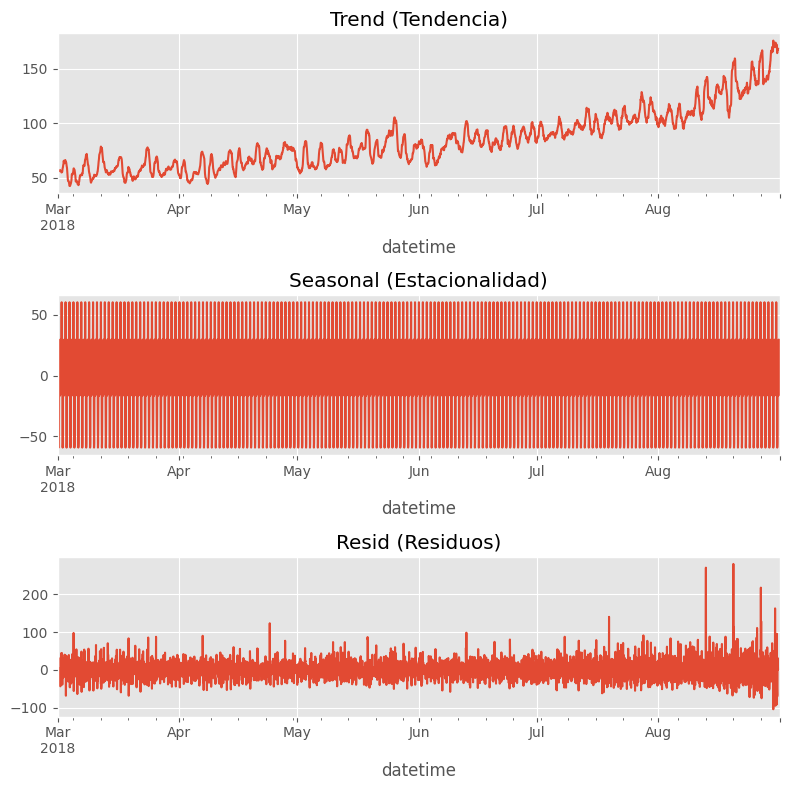

In [9]:
# descomponer en trend, seasonal y residual
decompose = seasonal_decompose(data_resample)

# Creación de gráficos
plt.figure(figsize=(8,8))
plt.subplot(311)
decompose.trend.plot(ax=plt.gca())
plt.title('Trend (Tendencia)')
plt.subplot(312)
decompose.seasonal.plot(ax=plt.gca())
plt.title('Seasonal (Estacionalidad)')
plt.subplot(313)
decompose.resid.plot(ax=plt.gca())
plt.title('Resid (Residuos)')
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<b>Conclusión parcial</b> <a class="tocSkip"></a>

- Se detecta una `tendencia` creciente a lo largo del periodo de los datos
- Se observa una estacionalidad, es decir un patrón repetitivo cada periodo determinado (1 día)
    - Para comprobarlo se muestra un gráfico de la estacionalidad de varios días
</div>

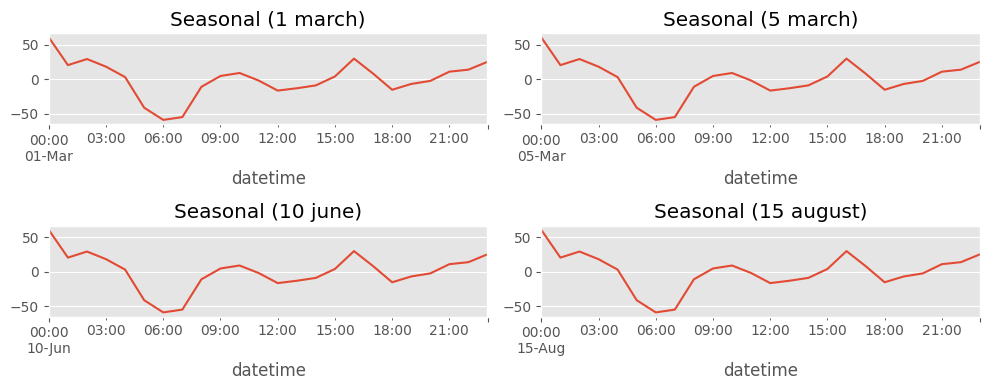

In [10]:
# Gráficos de estacionalidad
plt.figure(figsize=(10, 4))
plt.subplot(221)
decompose.seasonal['1 march 2018'].plot(ax=plt.gca())
plt.title('Seasonal (1 march)')
plt.subplot(222)
decompose.seasonal['5 march 2018'].plot(ax=plt.gca())
plt.title('Seasonal (5 march)')
plt.subplot(223)
decompose.seasonal['10 june 2018'].plot(ax=plt.gca())
plt.title('Seasonal (10 june)')
plt.subplot(224)
decompose.seasonal['15 august 2018'].plot(ax=plt.gca())
plt.title('Seasonal (15 august)')

plt.tight_layout()
plt.show()

## Formación

#### Creación de nuevas características para usar en el modelo

In [11]:
# Función para creación de nuevas características
def new_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['trend'] = decompose.trend
    data['seasonaly'] = decompose.seasonal
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

#### Creación de Dataset para el modelo

In [12]:
new_features(data_resample, 4, 7)
data_resample.head(11)

,num_orders,month,day,day_of_week,hour,trend,seasonaly,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,60.248112,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,NaN,20.177074,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,NaN,28.982743,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,NaN,17.885407,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,NaN,2.791145,66.0,71.0,85.0,124.0,NaN
2018-03-01 05:00:00,6,3,1,3,5,NaN,-41.563022,43.0,66.0,71.0,85.0,NaN
2018-03-01 06:00:00,12,3,1,3,6,NaN,-59.182671,6.0,43.0,66.0,71.0,NaN
2018-03-01 07:00:00,15,3,1,3,7,NaN,-55.104461,12.0,6.0,43.0,66.0,58.142857
2018-03-01 08:00:00,34,3,1,3,8,NaN,-11.212840,15.0,12.0,6.0,43.0,42.571429


In [13]:
# Quitar datos ausentes
data_modelo = data_resample.dropna()
data_modelo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-01 12:00:00 to 2018-08-31 11:00:00
Freq: h
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   int64  
 1   month         4392 non-null   int32  
 2   day           4392 non-null   int32  
 3   day_of_week   4392 non-null   int32  
 4   hour          4392 non-null   int32  
 5   trend         4392 non-null   float64
 6   seasonaly     4392 non-null   float64
 7   lag_1         4392 non-null   float64
 8   lag_2         4392 non-null   float64
 9   lag_3         4392 non-null   float64
 10  lag_4         4392 non-null   float64
 11  rolling_mean  4392 non-null   float64
dtypes: float64(7), int32(4), int64(1)
memory usage: 377.4 KB


<div class="alert alert-block alert-info">
<b>Conclusión parcial</b> <a class="tocSkip"></a>

- Se crean nuevas características a partir de la descomposición del índice (mes, día, día de la semana y hora), además de 4 horas previas de lag, rolling mean de 7 horas, la tendencia y estacionalidad.
	- Estas características permitirán entrenar el modelo y mejorar su precisión

</div>

#### División de los datos para entrenamiento y prueba

In [14]:
# entrenamiento y prueba
train, test = train_test_split(data_modelo, shuffle=False, test_size=0.1)


#### Verificar que los rangos para cada subconjunto sean continuos

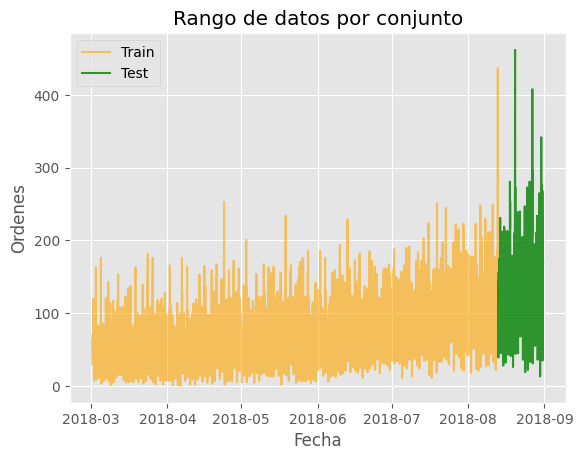

In [15]:
plt.plot(train['num_orders'], label='Train', color='orange', alpha=0.6)
plt.plot(test['num_orders'], label='Test', color='green', alpha=0.8)
plt.legend()
plt.title('Rango de datos por conjunto')
plt.xlabel('Fecha')
plt.ylabel('Ordenes')
plt.show()

In [16]:
print('Valor mínimo de entrenamiento:', train.index.min(), ', valor máximo:', train.index.max())
print()
print('Valor mínimo de Prueba:', test.index.min(), ', valor máximo:', test.index.max())

Valor mínimo de entrenamiento: 2018-03-01 12:00:00 , valor máximo: 2018-08-13 03:00:00

Valor mínimo de Prueba: 2018-08-13 04:00:00 , valor máximo: 2018-08-31 11:00:00


#### Configurar `features` y `target` para los conjuntos de datos y función RMSE

In [17]:
# Separar las columnas de características y objetivos de entrenamiento y test
# Conjunto entrenamiento
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
# Conjunto prueba
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [18]:
# Definir función RMSE
def rmse(target, prediction):
    return math.sqrt(mean_squared_error(target, prediction))

<div class="alert alert-block alert-info">
<b>Conclusión parcial</b> <a class="tocSkip"></a>

- Se separan los datos en subconjuntos de `train` y `test` dejando el 10% para `test`
	- Se comprueba la continuidad de los datos de los subconjuntos
- Se definen las características y objetivos para cada conjunto de datos
- Y se crea la función para calcular la raíz del error cuadrático medio (`RMSE`)

</div>

## Prueba

### Creación de modelos

#### Modelo de regresión Lineal

In [19]:
# Creación de modelo
model_rl = LinearRegression()

In [20]:
# Entrenamiento
model_rl.fit(features_train, target_train)

LinearRegression()

In [21]:
# Predicción con conjunto de entrenamiento y validación
pred_train_rl = model_rl.predict(features_train)

In [22]:
# Evaluación del modelo con los conjuntos de entrenamiento y validación
print('Modelo LinearRegressor')
print(f'El valor del RMSE para el conjunto de entrenamiento es:{rmse(target_train, pred_train_rl): .4f}')

Modelo LinearRegressor
El valor del RMSE para el conjunto de entrenamiento es: 22.0961


#### Modelo LightGBM Regressor

In [23]:
# Creación del modelo
model_lgbmr = LGBMRegressor(
    learning_rate=0.03,# tenia 0.05
    #num_interations=2000,
    objective='rmse',
    n_estimators=100,
    max_depth=100,#3000
    early_stopping_round=5,
    num_leaves=5#10
)

In [24]:
# Entrenamiento
model_lgbmr.fit(
    features_train,
    target_train,
    eval_set=(features_train, target_train)
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 11
[LightGBM] [Info] Start training from score 78.282389


c:\Users\jorar\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\callback.py:341: UserWarning: Only training set found, disabling early stopping.
  _log_warning("Only training set found, disabling early stopping.")
c:\Users\jorar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMRegressor(early_stopping_round=5, learning_rate=0.03, max_depth=100,
              num_leaves=5, objective='rmse')

In [25]:
# Predicción con conjunto de entrenamiento y validación
pred_train_lgbmr = model_lgbmr.predict(features_train)

In [26]:
# Evaluación del modelo
print('Modelo LightGBMRegressor')
print(f'El valor del RMSE para el conjunto de entrenamiento es:{rmse(target_train, pred_train_lgbmr): .4f}')

Modelo LightGBMRegressor
El valor del RMSE para el conjunto de entrenamiento es: 21.4763


#### Modelo CatBoost

In [27]:
# Creación del modelo
model_catB = CatBoostRegressor(
    learning_rate=0.5,
    loss_function='RMSE',
    metric_period=100,
    iterations=300#2000
)

In [28]:
# Entrenamiento
model_catB.fit(
    features_train,
    target_train,
    eval_set=(features_train,
            target_train),
    use_best_model=True
)

0:	learn: 28.7681857	test: 28.7681857	best: 28.7681857 (0)	total: 123ms	remaining: 36.7s
100:	learn: 12.4653919	test: 12.4653919	best: 12.4653919 (100)	total: 463ms	remaining: 913ms
200:	learn: 8.9833236	test: 8.9833236	best: 8.9833236 (200)	total: 729ms	remaining: 359ms
299:	learn: 6.7470021	test: 6.7470021	best: 6.7470021 (299)	total: 1s	remaining: 0us

bestTest = 6.747002073
bestIteration = 299



In [29]:
# Predicción con conjunto de entrenamiento y validación
pred_train_cat = model_catB.predict(features_train)

In [30]:
# Evaluación del modelo
print('Modelo CatBoostRegressor')
print(f'El valor del RMSE para el conjunto de entrenamiento es:{rmse(target_train, pred_train_cat): .4f}')

Modelo CatBoostRegressor
El valor del RMSE para el conjunto de entrenamiento es: 6.7470


#### Modelo Random Forest Regresor

In [31]:
# Creación del modelo
model_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=100,
    min_samples_split=100)
model_rf.fit(features_train, target_train)

RandomForestRegressor(max_depth=100, min_samples_split=100, n_estimators=200)

In [32]:
# Entrenamiento
pred_train_rf = model_rf.predict(features_train)


# Evaluación del modelo
print('Modelo Random Forest Regressor')
print(f'El valor del RMSE para el conjunto de entrenamiento es:{rmse(target_train, pred_train_rf): .4f}')

Modelo Random Forest Regressor
El valor del RMSE para el conjunto de entrenamiento es: 19.4688


#### Modelo XBoost Regresor

In [33]:
from xgboost import XGBRegressor

# Creación del modelo
model_XGBR = XGBRegressor()
model_XGBR.fit(features_train, target_train)

# Entrenamieno
pred_train_XGBR = model_XGBR.predict(features_train)

# Evaluación del modelo
print('Modelo XGBRegressor')
print(f'El valor del RMSE para el conjunto de entrenamiento es:{rmse(target_train, pred_train_XGBR): .4f}')

Modelo XGBRegressor
El valor del RMSE para el conjunto de entrenamiento es: 6.6383


#### Gráfica de resultados RMSE

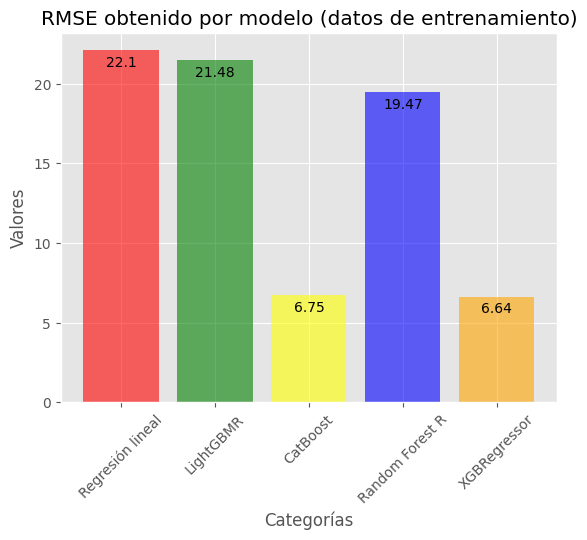

In [34]:
# Datos
categorias = ['Regresión lineal', 'LightGBMR', 'CatBoost', 'Random Forest R', 'XGBRegressor']
rmse_valores = [rmse(target_train, pred_train_rl),
                rmse(target_train, pred_train_lgbmr),
                rmse(target_train, pred_train_cat),
                rmse(target_train, pred_train_rf),
                rmse(target_train, pred_train_XGBR)]
colores = ['red', 'green', 'yellow', 'blue', 'orange']

# Crear la gráfica de barras
plt.bar(categorias, rmse_valores, color=colores, alpha=0.6)

# Agregar los valores encima de cada barra
for i in range(len(categorias)):
    plt.text(
        categorias[i], 
        rmse_valores[i] - 1.2, 
        str(round(rmse_valores[i], 2)), 
        ha='center', 
        va='bottom')

# Agregar título y etiquetas
plt.title('RMSE obtenido por modelo (datos de entrenamiento)')
plt.xlabel('Categorías')
plt.ylabel('Valores')

# Ajustar la posición y la orientación de los nombres de las categorías
plt.xticks(rotation=45, ha='center')

# Mostrar la gráfica
plt.show()

<div class="alert alert-block alert-info">
<b>Conclusión parcial</b> <a class="tocSkip"></a>

- Se crean diferentes modelos y se entrenan:
	- Regresión lineal
	- LightGBMR
	- CatBoost
	- Random Forest Regressor
	- XGB Regressor
- Se realiza prueba con el conjunto de entrenamiento:
	- En general con esos conjuntos se obtienen buenos resultados del `RMSE`
	- El mejor valor obtenido para el conjunto de entrenamiento se obtiene con el modelo `XGB Regressor`

</div>

## Evaluación de modelos

In [35]:
# Regresión lineal
pred_test_lr = model_rl.predict(features_test)
print(f'El valor del RMSE para el conjunto de prueba es:{rmse(target_test, pred_test_lr): .4f}')

El valor del RMSE para el conjunto de prueba es: 40.5990


In [36]:
# LightGBMR
pred_test_lgbmr = model_lgbmr.predict(features_test)
print(f'El valor del RMSE para el conjunto de prueba es:{rmse(target_test, pred_test_lgbmr): .4f}')

El valor del RMSE para el conjunto de prueba es: 45.5096


In [37]:
# CatBoost
pred_test_cat = model_catB.predict(features_test)
print(f'El valor del RMSE para el conjunto de prueba es:{rmse(target_test, pred_test_cat): .4f}')

El valor del RMSE para el conjunto de prueba es: 41.9306


In [38]:
# Random Forest Regressor
pred_test_rf = model_rf.predict(features_test)
print(f'El valor del RMSE para el conjunto de prueba es:{rmse(target_test, pred_test_rf): .4f}')

#50.7264 max deep 3000

El valor del RMSE para el conjunto de prueba es: 40.9745


In [39]:
# Random XGBRegressor
pred_test_XGBR = model_XGBR.predict(features_test)
print(f'El valor del RMSE para el conjunto de prueba es:{rmse(target_test, pred_test_XGBR): .4f}')

El valor del RMSE para el conjunto de prueba es: 43.6178


# Completar las demás columnas equivalentes a las predicciones de los modelos

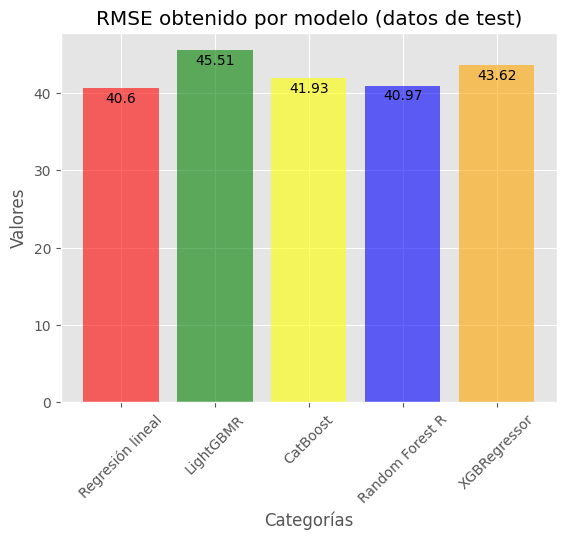

In [40]:
# Datos
categorias = ['Regresión lineal', 'LightGBMR', 'CatBoost', 'Random Forest R', 'XGBRegressor']
rmse_valores = [rmse(target_test, pred_test_lr),
                rmse(target_test, pred_test_lgbmr),
                rmse(target_test, pred_test_cat),
                rmse(target_test, pred_test_rf),
                rmse(target_test, pred_test_XGBR)]
colores = ['red', 'green', 'yellow', 'blue', 'orange']

# Crear la gráfica de barras
plt.bar(categorias, rmse_valores, color=colores, alpha=0.6)

# Agregar los valores encima de cada barra
for i in range(len(categorias)):
    plt.text(
        categorias[i], 
        rmse_valores[i] - 2.2, 
        str(round(rmse_valores[i], 2)), 
        ha='center', 
        va='bottom')

# Agregar título y etiquetas
plt.title('RMSE obtenido por modelo (datos de test)')
plt.xlabel('Categorías')
plt.ylabel('Valores')

# Ajustar la posición y la orientación de los nombres de las categorías
plt.xticks(rotation=45, ha='center')

# Mostrar la gráfica
plt.show()

<div class="alert alert-block alert-info">
<b>Conclusión parcial</b> <a class="tocSkip"></a>

- Después de realizar la evaluación final del modelo con el conjunto de datos `test` se observa lo siguiente:
	- Los 5 modelos usados están por debajo de la calificación de `RMSE` propuesta (`48`)
	- El modelo que obtiene la mejor evaluación es el `Random Forest` y el que tiene la mayor puntuación es `LightGBMR`

</div>

# Ejemplo de implementación

In [41]:
import joblib

joblib.dump(model_rf, 'model_rf.pkl')

['model_rf.pkl']

In [42]:
from datetime import datetime, timedelta

# 1. Simulamos un nuevo dato en tiempo real (última hora disponible)
hora_actual = datetime.now().replace(minute=0, second=0, microsecond=0)
nuevo_registro = pd.DataFrame({
    'datetime': [hora_actual],
})

# 2. Procesamiento de características similares al entrenamiento
nuevo_registro['month'] = nuevo_registro['datetime'].dt.month
nuevo_registro['day'] = nuevo_registro['datetime'].dt.day
nuevo_registro['day_of_week'] = nuevo_registro['datetime'].dt.weekday
nuevo_registro['hour'] = nuevo_registro['datetime'].dt.hour

# 3. Simulación de características adicionales
# Estos valores normalmente se calculan con datos históricos
nuevo_registro['lag_1'] = [245]            # ejemplo: número de viajes hace 1 hora
nuevo_registro['lag_2'] = [230]
nuevo_registro['lag_3'] = [210]
nuevo_registro['lag_4'] = [215]
nuevo_registro['rolling_mean'] = [225]  # media de últimas horas
nuevo_registro['trend'] = [1]          # creciente
nuevo_registro['seasonaly'] = [1]     # patrón diario activo

# 4. Cargar modelo entrenado
modelo = joblib.load("model_rf.pkl")

# 5. Selección de features usadas en el entrenamiento
features = ['month', 'day', 'day_of_week', 'hour',
            'trend', 'seasonaly', 'lag_1', 'lag_2',
            'lag_3', 'lag_4', 'rolling_mean', ]

# 6. Generar predicción
prediccion = modelo.predict(nuevo_registro[features])
print(f"🚕 Predicción de demanda de taxis para la siguiente hora: {round(prediccion[0], 0)} viajes")

🚕 Predicción de demanda de taxis para la siguiente hora: 48.0 viajes


# Conclusiones generales



### Preparación y análisis

- Se verificó la correcta tipificación de los datos, configurando la columna `datetime` como índice temporal. Esto aseguró el orden cronológico de los registros y confirmó la ausencia de valores nulos.
- Se aplicó un `resample` por hora, reduciendo el volumen de registros de 26,496 a 4,416, facilitando el análisis temporal.
- El análisis inicial reveló una tendencia creciente y una estacionalidad diaria clara, justificando el enfoque basado en series temporales.

### Formación de características

- Se generaron variables relevantes como mes, día, día de la semana y hora, además de lag de 4 horas, media móvil de 7 horas y componentes de tendencia y estacionalidad.
- Los datos fueron divididos en conjuntos `train` y `test`, reservando el 10% para evaluación. Se comprobó la continuidad temporal y se definieron correctamente las variables independientes (`features`) y dependientes (`target`).

### Entrenamiento de modelos

- Se entrenaron cinco modelos de regresión:
  - Regresión Lineal
  - LightGBM Regressor
  - CatBoost Regressor
  - Random Forest Regressor
  - XGBoost Regressor
- El modelo `XGBoost` obtuvo el menor valor de `RMSE` en el conjunto de entrenamiento, destacándose por su capacidad de ajuste.

### Evaluación de modelos

- Todos los modelos evaluados cumplieron con el criterio de `RMSE < 48` en el conjunto de prueba.
- El modelo `Random Forest` mostró el mejor rendimiento en datos no vistos.
- Se observó que `LightGBMR` obtuvo el `RMSE` más alto dentro del grupo, aunque aún dentro del umbral aceptable.
